In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchtext.transforms as T
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.schemas import NlpContext
from torchlake.common.utils.platform import get_num_workers
from torchlake.common.utils.text import build_vocab
from torchlake.sequence_data.models import (Seq2Seq, Seq2SeqAttentionEncoder,
                                            Seq2SeqDecoder, Seq2SeqEncoder)
from torchlake.sequence_data.models.seq2seq.network import (GlobalAttention,
                                                            LocalAttention)
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import Multi30k
from tqdm import tqdm

To utilize this notebook, you have to install `spacy` and download `de_core_news_sm` and `en_core_web_sm` first

# setting

In [2]:
data_path = Path("../../data/multi30k")
artifacts_path = Path("../../artifacts/seq2seq")

In [3]:
BATCH_SIZE = 64
context = NlpContext()

In [4]:
device = torch.device(context.device)

# data

In [5]:
SRC_LANGUAGE = 'de'
TRG_LANGUAGE = 'en'

In [6]:
tokenizers = {
    SRC_LANGUAGE: get_tokenizer('spacy', language=SRC_LANGUAGE), # de_core_news_sm
    TRG_LANGUAGE: get_tokenizer('spacy', language=TRG_LANGUAGE)  # en_web_core_sm
}

/opt/conda/lib/python3.10/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "de" could not be loaded, trying "de_core_news_sm" instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [7]:
train_iter, val_iter, test_iter = Multi30k(
    data_path.as_posix(),
    language_pair=(SRC_LANGUAGE, TRG_LANGUAGE),
)

In [8]:
vocabs = {
    SRC_LANGUAGE: build_vocab(map(lambda x: tokenizers[SRC_LANGUAGE](x[0]), train_iter), context),
    TRG_LANGUAGE: build_vocab(map(lambda x: tokenizers[SRC_LANGUAGE](x[1]), train_iter), context),
}

/opt/conda/lib/python3.10/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [9]:
vocab_sizes = {
    SRC_LANGUAGE: len(vocabs[SRC_LANGUAGE]),
    TRG_LANGUAGE: len(vocabs[TRG_LANGUAGE]),
}

In [10]:
src_transform = T.Sequential(
    T.VocabTransform(vocabs[SRC_LANGUAGE]),
    T.Truncate(context.max_seq_len - 2),
    T.AddToken(token=context.bos_idx, begin=True),
    T.AddToken(token=context.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(context.max_seq_len, context.padding_idx),
)

trg_transform = T.Sequential(
    T.VocabTransform(vocabs[TRG_LANGUAGE]),
    T.Truncate(context.max_seq_len - 2),
    T.AddToken(token=context.bos_idx, begin=True),
    T.AddToken(token=context.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(context.max_seq_len, context.padding_idx),
)

In [11]:
def collate_fn(batch):
    src_batch, tgt_batch = [], []

    for src_sample, trg_sample in batch:
        # paper p.2: reverse source sentence
        src_sample = src_sample[::-1]
        
        src_tokenizer  = tokenizers[SRC_LANGUAGE]
        src_batch.append(src_transform(src_tokenizer(src_sample.rstrip("\n"))))
        
        trg_tokenizer  = tokenizers[TRG_LANGUAGE]
        tgt_batch.append(trg_transform(trg_tokenizer(trg_sample.rstrip("\n"))))

    return torch.stack(src_batch), torch.stack(tgt_batch)

In [12]:
NUM_WORKERS = get_num_workers()

In [13]:
train_loader = DataLoader(
    train_iter,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    val_iter,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
)

In [14]:
for src, trg in train_loader:
    print(src.shape, trg.shape)
    break

torch.Size([64, 256]) torch.Size([64, 256])


# Model

In [15]:
NUM_LAYERS = 1
BIDIRECTIONAL = True

# encoder = Seq2SeqEncoder(
#     vocab_sizes[SRC_LANGUAGE],
#     128,
#     128,
#     num_layers=NUM_LAYERS,
#     bidirectional=BIDIRECTIONAL,
#     context=context,
# )

encoder = Seq2SeqAttentionEncoder(
    vocab_sizes[SRC_LANGUAGE],
    128,
    128,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    context=context,
)

decoder = Seq2SeqDecoder(
    vocab_sizes[TRG_LANGUAGE],
    128,
    128,
    output_size=vocab_sizes[TRG_LANGUAGE],
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    context=context,
)

# attention = None 
# attention = GlobalAttention(128, num_layers=NUM_LAYERS, bidirectional=BIDIRECTIONAL)
attention = LocalAttention(128, num_layers=NUM_LAYERS, bidirectional=BIDIRECTIONAL)

model = Seq2Seq(encoder, decoder, attention, context=context).to(device)

In [16]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Seq2Seq                                  --
├─Seq2SeqEncoder: 1-1                    --
│    └─LstmClassifier: 2-1               --
│    │    └─Embedding: 3-1               464,640
│    │    └─LSTM: 3-2                    1,449,984
│    │    └─LayerNorm: 3-3               512
├─Seq2SeqDecoder: 1-2                    --
│    └─LstmClassifier: 2-2               --
│    │    └─Embedding: 3-4               430,720
│    │    └─LSTM: 3-5                    1,449,984
│    │    └─LayerNorm: 3-6               512
│    │    └─Linear: 3-7                  864,805
Total params: 4,661,157
Trainable params: 4,661,157
Non-trainable params: 0

# Training

In [17]:
criterion = nn.CrossEntropyLoss(ignore_index = context.padding_idx)
optimizer = torch.optim.Adam(model.parameters())

In [18]:
epoches = 10

In [ ]:
model.train()
training_loss = []
for e in range(epoches):
    running_loss = 0.0
    data_count = 0
    
    for source_sentence, target_sentence in tqdm(train_loader):
        data_count += len(source_sentence)
        optimizer.zero_grad()

        text = source_sentence.to(device)
        label = target_sentence.to(device)

        output = model.loss_forward(text, label)
        loss = criterion(output.transpose(-1, -2), label)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    mean_loss = running_loss / data_count
    training_loss.append(mean_loss)
    print(f"epoch {e+1} : {mean_loss}")

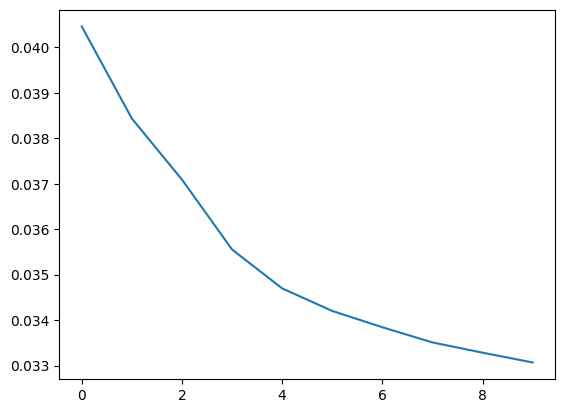

In [20]:
# plain, 4, bi
plt.plot(training_loss)

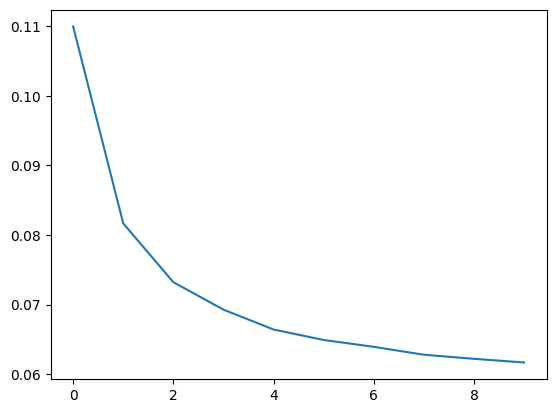

In [20]:
# local, 1, uni
plt.plot(training_loss)

# Evaluate

In [21]:
from torchmetrics.text import Perplexity

In [23]:
metric = Perplexity(ignore_index=context.padding_idx)

In [26]:
model.eval()
running_loss = 0.0
data_count = 0
with torch.no_grad():
    for source_sentence, target_sentence in tqdm(test_loader):
        # data_count += len(source_sentence)
        text = source_sentence.to(device)
        label = target_sentence.to(device)
        # label = label[1:].view(-1)

        output = model.predict(text, topk=2)
        # output = torch.flatten(output[:, 1:], end_dim=-2)

        # loss = criterion(output.transpose(-1, -2), label)
        # running_loss += loss.item()
        metric.update(output.detach().cpu(), label.detach().cpu())

    # mean_loss = running_loss / data_count

# print(f"loss: {mean_loss}")
# print(f"perplexity: {math.exp(mean_loss)}")

0it [00:00, ?it/s]d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
7it [00:09,  1.36s/it]d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\_jit_internal.py:1355: UserWarning: The inner type of a container is lost when calling torch.jit.isinstance in eager mode. For example, List[int] would become list and therefore falsely return True for List[float] or List[str].
  warnings.warn(
8it [00:11,  1.38s/it]


In [27]:
metric.compute()

tensor(146.6560)

In [19]:
from torchmetrics.text import BLEUScore

In [20]:
metric = BLEUScore()

In [ ]:
model.eval()
running_loss = 0.0
data_count = 0
with torch.no_grad():
    for source_sentence, target_sentence in tqdm(test_loader):
        data_count += len(source_sentence)
        text = source_sentence.to(device)
        label = target_sentence.to(device)

        output = model(text, teacher_forcing_ratio=0).argmax(-1)
        
        preds = []
        for o in output.tolist():
            translated = vocabs[TRG_LANGUAGE].lookup_tokens(o)
            start_idx, end_idx = translated.index(context.bos_str), translated.index(context.eos_str)
            preds.append(" ".join(translated[start_idx+1 : end_idx]))
            
        labels = []
        for l in label.tolist():
            translated = vocabs[TRG_LANGUAGE].lookup_tokens(l)
            start_idx, end_idx = translated.index(context.bos_str), translated.index(context.eos_str)
            labels.append(" ".join(translated[start_idx+1 : end_idx]))
            
        metric.update(preds, labels)

In [ ]:
metric.compute()

# Translate

In [44]:
CLIP = 20

model.eval()
with torch.no_grad():
    for i, (source_sentence, target_sentence) in enumerate(val_iter):
        ori_source, ori_target = source_sentence, target_sentence
        source_sentence = tokenizers[SRC_LANGUAGE](source_sentence.rstrip('\n'))
        source_sentence = src_transform(source_sentence)
        source_sentence = source_sentence.unsqueeze(0)
        source_sentence = source_sentence.to(device)
        
        target_sentence = tokenizers[TRG_LANGUAGE](target_sentence.rstrip('\n'))
        target_sentence = trg_transform(target_sentence)
        target_sentence = target_sentence.unsqueeze(0)
        target_sentence = target_sentence.to(device)
        
        # outputs = [BOS_IDX]
        
        # h, c = model.encoder(source_sentence)
        
        # for _ in range(MAX_LENGTH):
            
        #     input_seq = torch.LongTensor([outputs[-1]]).to(device)
            
        #     output, _, _ = model.decoder(input_seq, h, c)
            
        #     next_token = output.argmax(1).item()
        #     outputs.append(next_token) 
            
        #     if next_token == EOS_IDX: break
        
        output = model(source_sentence, target_sentence)[0].argmax(-1)
        
        # if EOS_IDX in outputs:
        translated = vocabs[TRG_LANGUAGE].lookup_tokens(output.tolist())
        start_idx, end_idx = translated.index(context.bos_str), translated.index(context.eos_str)
        print(f'第{i+1}句')
        print('source:', ori_source.rstrip('\n'))
        print('target:', ori_target.rstrip('\n'))
        print('output:', *translated[start_idx+1:end_idx], sep=' ')
        
        if i+1==CLIP: break

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


第1句
source: Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
target: A group of men are loading cotton onto a truck
output: A man of men are sitting cotton onto a truck
第2句
source: Ein Mann schläft in einem grünen Raum auf einem Sofa.
target: A man sleeping in a green room on a couch.
output: A man in a a a room on a couch .
第3句
source: Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
target: A boy wearing headphones sits on a woman's shoulders.
output: A man wearing headphones and and a woman <unk> shoulders .
第4句
source: Zwei Männer bauen eine blaue Eisfischerhütte auf einem zugefrorenen See auf
target: Two men setting up a blue ice fishing hut on an iced over lake
output: Two men setting up up blue ice cream hut on an <unk> over lake .
第5句
source: Ein Mann mit beginnender Glatze, der eine rote Rettungsweste trägt, sitzt in einem kleinen Boot.
target: A balding man wearing a red life jacket is sitting in a small boat.
output: A balding man in a blue life jacket 

# Save

In [28]:
model_name = 'seq2seq'
if model.attention is not None:
    if isinstance(model.attention, GlobalAttention):
        model_name += '.global'
    elif isinstance(model.attention, LocalAttention):
        model_name += '.local'

if model.decoder.rnn.factor == 2:
    model_name += '.bi'

model_path = artifacts_path / (model_name + '.pth')
print(model_path.as_posix())

../../artifacts/seq2seq/seq2seq.bi.pth


In [29]:
torch.save(model, model_path.as_posix())

In [38]:
model = torch.load(model_path.as_posix())